<a href="https://colab.research.google.com/github/romazzo89/romazzo89/blob/main/Trabajo-Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
conn = crear_conexion()
c = conn.cursor()
c.execute("DELETE FROM datos_acciones")  # Eliminar datos antiguos
conn.commit()
conn.close()



Menú:
1. Actualización de datos
2. Visualización de datos
3. Salir
Seleccione una opción: 1
Ingrese ticker a pedir: AAPL
Ingrese fecha de inicio (YYYY-MM-DD): 2024-12-14
Ingrese fecha de fin (YYYY-MM-DD): 2024-12-18
Pidiendo datos...
Datos guardados correctamente

Menú:
1. Actualización de datos
2. Visualización de datos
3. Salir
Seleccione una opción: 2
1. Resumen de datos guardados
2. Gráfico de datos
Seleccione una opción: 1
Los tickers guardados en la base de datos son:
AAPL - 2024-12-02 <-> 2024-12-18

Menú:
1. Actualización de datos
2. Visualización de datos
3. Salir
Seleccione una opción: 2
1. Resumen de datos guardados
2. Gráfico de datos
Seleccione una opción: 2
Ingrese el ticker a graficar: AAPL


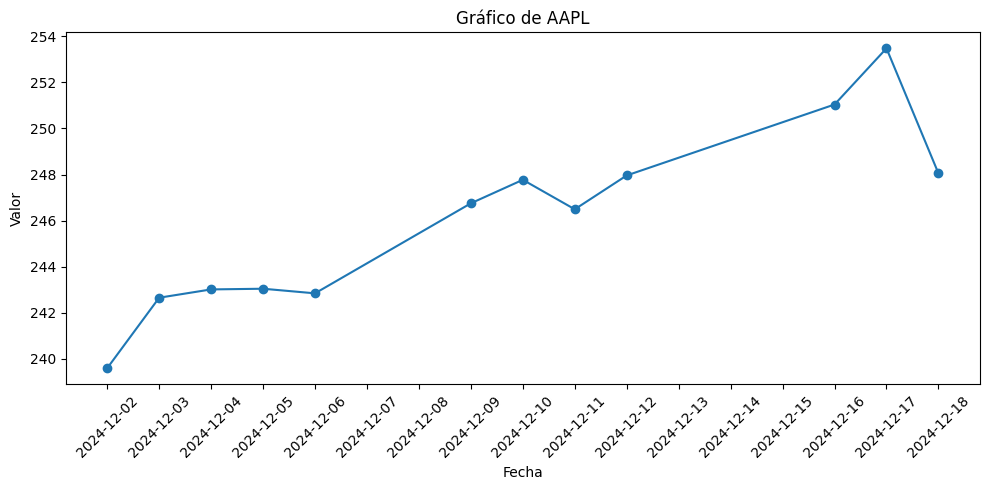


Menú:
1. Actualización de datos
2. Visualización de datos
3. Salir
Seleccione una opción: 3


In [6]:
import sqlite3
import requests
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

def crear_conexion():
    conn = sqlite3.connect('finanzas.db')
    return conn

def crear_tabla():
    conn = crear_conexion()
    c = conn.cursor()
    c.execute('''CREATE TABLE IF NOT EXISTS datos_acciones
                 (ticker TEXT, fecha_inicio TEXT, fecha_fin TEXT, valor REAL)''')
    conn.commit()
    conn.close()

def actualizar_datos():
    ticker = input("Ingrese ticker a pedir: ")
    fecha_inicio = input("Ingrese fecha de inicio (YYYY-MM-DD): ")
    fecha_fin = input("Ingrese fecha de fin (YYYY-MM-DD): ")

    try:
        datetime.strptime(fecha_inicio, '%Y-%m-%d')
        datetime.strptime(fecha_fin, '%Y-%m-%d')
    except ValueError:
        print("Fecha no válida. El formato debe ser YYYY-MM-DD.")
        return


    print("Pidiendo datos...")
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/day/{fecha_inicio}/{fecha_fin}?apiKey=9dPna0Rfqg22CT7cuuDId8f5SBDHlb0j"
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        guardar_datos(ticker, fecha_inicio, fecha_fin, data)
        print("Datos guardados correctamente")
    except requests.exceptions.HTTPError as errh:
        print(f"Error HTTP: {errh}")
    except requests.exceptions.RequestException as err:
        print(f"Error al obtener los datos de la API: {err}")

def guardar_datos(ticker, fecha_inicio, fecha_fin, data):
    conn = crear_conexion()
    c = conn.cursor()

    for item in data['results']:
        fecha = datetime.fromtimestamp(item['t'] / 1000).strftime('%Y-%m-%d')  # Convertir timestamp a fecha
        c.execute('''INSERT INTO datos_acciones (ticker, fecha_inicio, fecha_fin, valor)
                     VALUES (?, ?, ?, ?)''', (ticker, fecha, fecha, item['c']))

    conn.commit()
    conn.close()

def mostrar_resumen():
    conn = crear_conexion()
    c = conn.cursor()
    c.execute("SELECT ticker, MIN(fecha_inicio), MAX(fecha_inicio) FROM datos_acciones GROUP BY ticker")
    rows = c.fetchall()

    if rows:
        print("Los tickers guardados en la base de datos son:")
        for row in rows:
            print(f"{row[0]} - {row[1]} <-> {row[2]}")
    else:
        print("No hay datos guardados en la base de datos.")

    conn.close()

def graficar_datos():
    ticker = input("Ingrese el ticker a graficar: ")

    conn = crear_conexion()
    c = conn.cursor()
    c.execute("SELECT fecha_inicio, valor FROM datos_acciones WHERE ticker=?", (ticker,))
    rows = c.fetchall()

    if rows:
        fechas = [datetime.strptime(row[0], '%Y-%m-%d') for row in rows]
        valores = [row[1] for row in rows]

        plt.figure(figsize=(10, 5))
        plt.plot(fechas, valores, marker='o')
        plt.xlabel('Fecha')
        plt.ylabel('Valor')
        plt.title(f'Gráfico de {ticker}')
        plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator())
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print(f"No hay datos guardados para el ticker {ticker}")

    conn.close()

def menu():
    while True:
        print("\nMenú:")
        print("1. Actualización de datos")
        print("2. Visualización de datos")
        print("3. Salir")

        opcion = input("Seleccione una opción: ")

        if opcion == '1':
            actualizar_datos()
        elif opcion == '2':
            print("1. Resumen de datos guardados")
            print("2. Gráfico de datos")
            sub_opcion = input("Seleccione una opción: ")
            if sub_opcion == '1':
                mostrar_resumen()
            elif sub_opcion == '2':
                graficar_datos()
        elif opcion == '3':
            break
        else:
            print("Opción no válida. Intente nuevamente.")

if __name__ == "__main__":
    crear_tabla()
    menu()

